In [1]:
import numpy as np
import pandas as pd
from renewableopt.data import DATASET_DIR, load_by_day

# Load Demand Response from CSV

In [2]:
sources = ["solar", "wind", "geothermal"]
time, load, generation_pu = load_by_day(0, 367, sources=sources, use_hr=True)

In [3]:
filename = DATASET_DIR / 'demand_response' / 'commercial_dr.csv'
dr = pd.read_csv(filename)

In [4]:
print(time.shape)

(105408,)


In [5]:
dr.columns

Index(['Demand (MW)', '100%', '75%', '50%', '25%'], dtype='object')

In [6]:
# Some data parsing to Demand response things happy...
dr = dr.iloc[:time.shape[0]]
dr = dr.rename(columns=lambda col: col if col != "Demand (MW)" else "Base Case")

In [7]:
for col in dr.columns:
    delta = np.array(dr[col] / load)
    print(f"{col}: {np.min(delta):.3f} {np.max(delta):.3f} {np.mean(delta):.3f}")

Base Case: 1.000 1.000 1.000
100%: 0.852 0.900 0.858
75%: 0.889 0.900 0.890
50%: 0.926 0.950 0.929
25%: 0.963 0.980 0.965


# Initialize Cost Scenarios

In [8]:
costs = pd.DataFrame({
    "Scenario 1: Base Case": [1250, 1250, 3500, 300, 350],
    "Scenario 2: No Geothermal": [1250, 1250, int(1e8), 300, 350]
    
}, index = [
    "Solar (K/MW)", "Wind cost (K/MW)", "Geothermal cost (K/MW)",
    "Battery energy cost (K/MWh)", "Battery power cost (K/MW)", 
])

In [9]:
costs

,Scenario 1: Base Case,Scenario 2: No Geothermal
Solar (K/MW),1250,1250
Wind cost (K/MW),1250,1250
Geothermal cost (K/MW),3500,100000000
Battery energy cost (K/MWh),300,300
Battery power cost (K/MW),350,350


# Convert generation data to DataFrame

In [10]:
import matplotlib.pyplot as plt

In [11]:
generation_pu[:10, 1]

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.99367885, 0.98735769, 0.98103654])

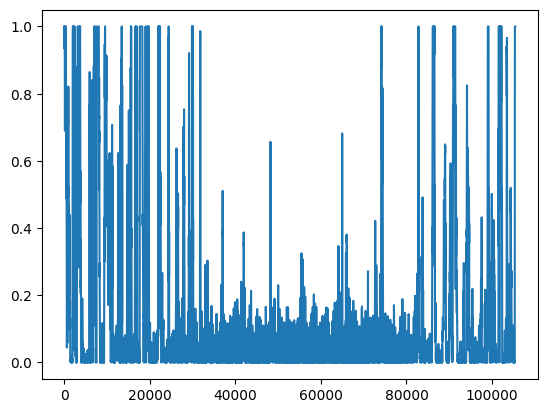

In [12]:
plt.plot(generation_pu[:, 1])

In [13]:
generation_df = pd.DataFrame({
    source: generation_pu[:, i]
    for i, source in enumerate(sources)
}, index=pd.Index(time, name="Time (hr)"))

In [14]:
generation_df

,solar,wind,geothermal
Time (hr),,,
0.000000,0.000000,1.0,1.0
0.083333,0.000000,1.0,1.0
0.166667,0.000000,1.0,1.0
0.250000,0.000000,1.0,1.0
0.333333,0.000000,1.0,1.0
...,...,...,...
8783.583333,0.714297,1.0,1.0
8783.666667,0.714297,1.0,1.0
8783.750000,0.714297,1.0,1.0


# Write Scenario data to Excel

In [15]:
excel_file = DATASET_DIR / "sensitivity_base" / "sensitivity.xlsx"

In [16]:
# Write Scenarios data.
# NOTE this takes a while for whatever reason...
# I blame excel.
with pd.ExcelWriter(excel_file) as writer:
    costs.to_excel(writer, sheet_name="Cost Scenarios")
    dr.to_excel(writer, sheet_name="Load Scenarios")
    generation_df.to_excel(writer, sheet_name="Generation")